In [1]:
# Wave‑climate variability (2010–2024)
# -----------------------------------------------------------
# Reproduce Figs 2–4 of *Chien et al. 2014* for 2010‑2024 using:
#   • Taiwan coastal buoys (Longdong, Hualien, Hsinchu)
#   • NOAA/NDBC buoy #52200 (western Pacific reference)
#
# Directory structure assumed (edit if different):
#   /buoy
#       └── data/
#           ├── Longdong/  2010.csv … 2024.csv
#           ├── Hualien/   2010.csv … 2024.csv
#           └── Hsinchu/   2010.csv … 2024.csv
# -----------------------------------------------------------

import io, requests, warnings
from pathlib import Path
from typing import List, Literal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 


In [5]:
# ------------------------------------------------------------------
# 1. Helpers to ingest local Taiwan‑CWB buoy files
# ------------------------------------------------------------------
CWB_ROOT = Path("../data")  # edit to actual root if needed
CWB_SITES = {
    "Longdong": (25.0969, 121.9222),
    "Hualien":  (24.0311, 121.6325),
    "Hsinchu":  (24.7625, 120.8422),

}
CWB_WAVE_COL = "示性波高"     # significant wave height (m)
CWB_WIND_COL = "風速"         # wind speed (m/s) – adjust if column differs
CWB_TIME_COL = "時間"          # timestamp (UTC+8)

# Other global variables
ROLL_3M = "2190h"   # 90 days ≈ 3 months (24*90 = 2160 h, add margin)
ROLL_1Y = "8760h"   # 365 days in hours

In [6]:
def read_cwb_site(site: str, years: range | List[int] = range(2010, 2025)) -> pd.DataFrame:
    """Load & concatenate hourly records for a given CWB buoy site."""
    frames: List[pd.DataFrame] = []
    site_dir = CWB_ROOT / site
    for y in years:
        f = site_dir / f"{y}.csv"
        if not f.exists():
            warnings.warn(f"missing file {f}")
            continue
        # skip the units row (second row) & dtype infer
        df = pd.read_csv(f, skiprows=[1, 2], low_memory=False)
        # rename & parse time
        df = df.rename(columns={CWB_TIME_COL: "time", CWB_WAVE_COL: "Hs", CWB_WIND_COL: "Wind"})
        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        df = df.dropna(subset=["time"]).set_index("time")
        frames.append(df[["Hs", "Wind"]])
    if not frames:
        raise FileNotFoundError(f"No CSV files found for {site}")
    out = pd.concat(frames).sort_index()
    out["site"] = site
    return out

def plot_monthly_wind(master: pd.DataFrame):
    """Reproduce Fig. 2 – monthly‑mean wind speed by site."""
    fig, ax = plt.subplots(figsize=(10, 5))
    for site, grp in master.groupby("site"):
        monthly = grp["Wind"].resample("ME").mean()
        ax.plot(monthly.index, monthly, label=site)
    ax.set_ylabel("Wind speed (m/s)")
    ax.set_title("Monthly‑mean wind speeds (2010–2024)")
    ax.legend()
    ax.grid(True, alpha=.3)
    fig.autofmt_xdate()

In [7]:
cwb_sites = [read_cwb_site(site) for site in CWB_SITES]
cwb_sites_df = pd.concat(cwb_sites).sort_index()


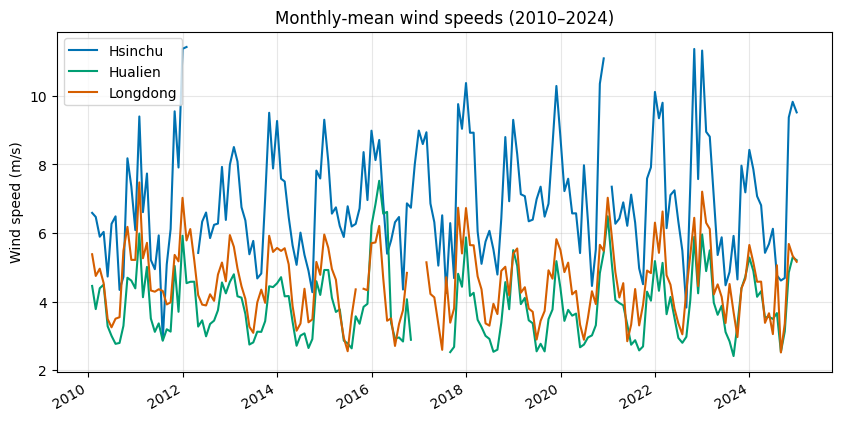

In [5]:
plt.style.use("seaborn-v0_8-colorblind")
plot_monthly_wind(cwb_sites_df)


In [8]:
# ------------------------------------------------------------------
# 2. Helpers to fetch NOAA/NDBC buoy 52200
# ------------------------------------------------------------------
NDBC_ID = "52200"
NDBC_BASE = "https://www.ndbc.noaa.gov/view_text_file.php"
NDBC_DIR = "../data/NOAA"

NDBC_COLS = ["year","month","day","hour","minute",
             "WDIR","WSPD","GST","WVHT","DPD","APD",
             "MWD","PRES","ATMP","WTMP","DEWP","VIS","TIDE"]

In [9]:
def load_or_download_ndbc(buoy: str, year: int) -> pd.DataFrame:
    local_dir = Path(f"{NDBC_DIR}/buoy_{buoy}") 
    local_dir.mkdir(parents=True, exist_ok=True)                  
    local_path = local_dir / f"{buoy}h{year}.txt"
    if not local_path.exists():
        params = {
            "filename": f"{buoy}h{year}.txt.gz",
            "dir": "data/historical/stdmet/",
        }
        r = requests.get(NDBC_BASE, params=params, timeout=60)
        r.raise_for_status()
        text = r.text
        local_path.write_text(text)
    else:
        text = local_path.read_text()

    lines = [ln for ln in text.splitlines() if not ln.lstrip().startswith('#')]
    if not lines:
        raise ValueError(f"No data for {buoy} {year}")
    df = pd.read_csv(io.StringIO("\n".join(lines)), sep=r'\s+',
                     names=NDBC_COLS, na_values={99.0,999.0,99.00,9999.0})
    # rename to lowercase for pandas datetime
    df = df.rename(columns={
        'WSPD':'Wind', 'WVHT':'Hs', 'WDIR':'Dir'
    })
    df['time'] = pd.to_datetime(df[['year','month','day','hour','minute']], errors='coerce')
    df = df.set_index('time').sort_index()
    return df[['Hs','Wind','Dir']].assign(site=f"NDBC_{buoy}")


def read_ndbc(buoy: str, years: range | List[int] = range(2010, 2025)) -> pd.DataFrame:
    frames = [load_or_download_ndbc(buoy, y) for y in years]
    return pd.concat(frames)

# ------------------------------------------------------------------
# 3. Build combined dataset (lazy – fetch once & cache locally)
# ------------------------------------------------------------------
def build_master(NOAA_buoy: List[str] = []) -> pd.DataFrame:
    """Return a single DataFrame with index‑aligned hourly data from all sites."""
    frames = [read_cwb_site(site) for site in CWB_SITES]
    for buoy in NOAA_buoy:
        frames.append(read_ndbc(buoy))
    return pd.concat(frames).sort_index()


In [10]:
def plot_monthly_hs(master: pd.DataFrame):
    """Reproduce Fig. 3 – monthly‑mean significant wave heights."""
    fig, ax = plt.subplots(figsize=(10, 5))
    for site, grp in master.groupby("site"):
        monthly = grp["Hs"].resample("ME").mean()
        ax.plot(monthly.index, monthly, label=site)
    ax.set_ylabel("Significant wave height Hs (m)")
    ax.set_title("Monthly‑mean Hs (2010–2024)")
    ax.legend()
    ax.grid(True, alpha=.3)
    fig.autofmt_xdate()

In [11]:
master_df = build_master(NOAA_buoy=[NDBC_ID])
print(master_df.head())

                       Hs  Wind        site  Dir
time                                            
2010-01-01 00:00:00  1.50   4.6    Longdong  NaN
2010-01-01 00:00:00  1.31   8.7     Hsinchu  NaN
2010-01-01 00:00:00  1.20   3.0     Hualien  NaN
2010-01-01 00:21:00  1.15   NaN  NDBC_52200  NaN
2010-01-01 00:51:00  1.18   NaN  NDBC_52200  NaN


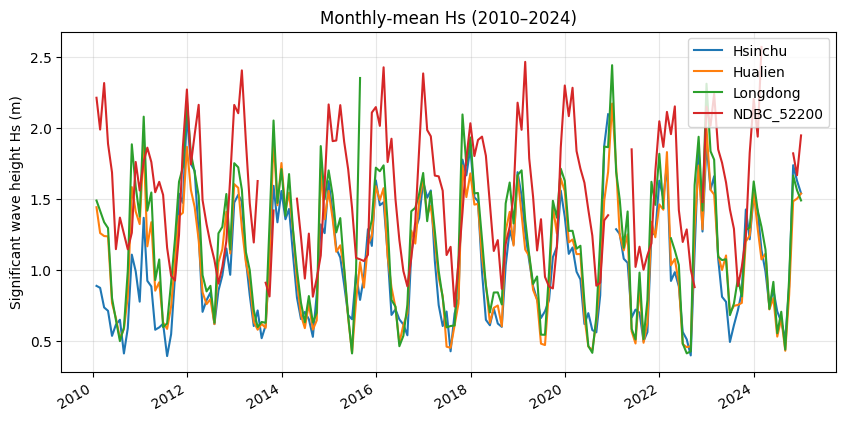

In [12]:
plot_monthly_hs(master_df)

In [15]:
def plot_multi_scale(df: pd.DataFrame,
                     var: Literal['Hs','Wind','Dir'],
                     clip_max: float | None = None):
    # only CWB sites
    sites = [s for s in df['site'].unique() if not s.startswith('NDBC_')]
    fig,axes = plt.subplots(len(sites),1,
                            figsize=(12,3*len(sites)),
                            sharex=True)
    for ax,site in zip(axes,sites):
        s = df.loc[df['site']==site, var]
        if clip_max is not None:
            s = s.where(s < clip_max)
        ax.plot(s, color='gray', alpha=0.3, label='Hourly')
        ax.plot(s.rolling(ROLL_3M).mean(), label='90D mean')
        ax.plot(s.rolling(ROLL_1Y).mean(), label='365D mean')
        ax.set_title(site)
        ax.set_ylim(0, clip_max or None)
        ax.legend()

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))        
    fig.suptitle(f'{var} multi-scale variation', y=0.95)
    plt.tight_layout(rect=[0,0,1,0.93])

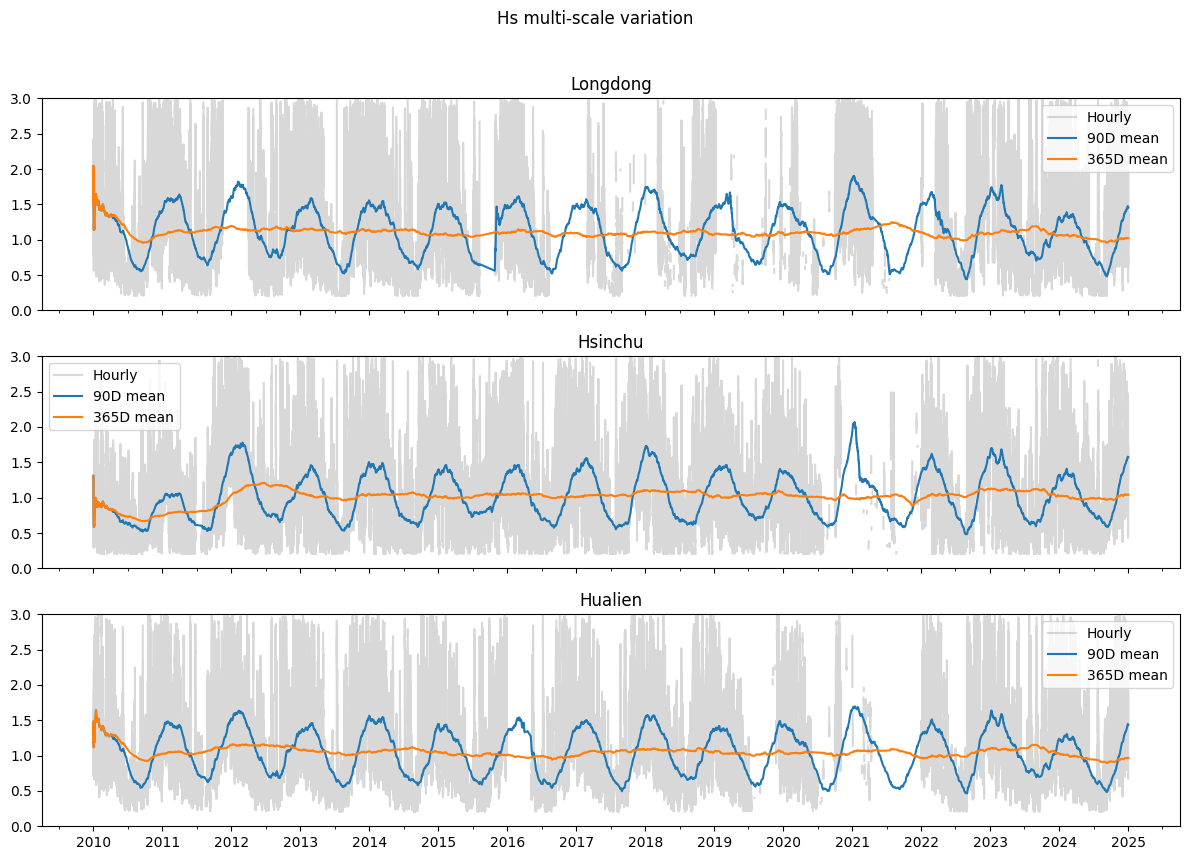

In [16]:
plot_multi_scale(master_df, 'Hs', clip_max=3.0)
plt.show()

In [17]:
from PyEMD import EEMD
import matplotlib.pyplot as plt
import numpy as np

def plot_eemd_decomposition(master_df: pd.DataFrame, site: str, var: str = "Hs", max_imfs: int = None):
    """
    Decompose daily-mean time series using EEMD and plot IMFs + trend.
    Parameters:
        master_df: full hourly dataset from build_master()
        site: site name (e.g., 'Longdong', 'Hualien')
        var: variable name (default: 'Hs')
        max_imfs: if specified, truncate the number of plotted IMFs
    """
    # Step 1: extract daily series and interpolate
    s = master_df.loc[master_df["site"] == site, var]
    daily = s.resample("D").mean()
    daily = daily.interpolate("time", limit=2).dropna()
    
    if daily.isna().sum() > 0 or len(daily) < 3000:
        raise ValueError("Too many gaps or not enough valid data for EEMD")

    x = daily.values
    t = np.arange(len(x))

    # Step 2: perform EEMD
    eemd = EEMD(trials=100, noise_width=0.2)
    #IMFs = eemd.eemd(x, t)
    #residual = x - IMFs.sum(axis=0)
    eemd.eemd(x, t)
    IMFs, residual = eemd.get_imfs_and_residue()

    # Step 3: plot
    n_imfs = IMFs.shape[0] if max_imfs is None else min(IMFs.shape[0], max_imfs)
    fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(12, 2.2*(n_imfs+1)), sharex=True)

    for i in range(n_imfs):
        axes[i].plot(daily.index, IMFs[i], label=f"IMF {i+1}")
        axes[i].legend(loc="upper right")
        axes[i].grid(alpha=0.3)

    axes[-1].plot(daily.index, residual, 'k', label="Residual (trend)")
    axes[-1].legend(loc="upper right")
    axes[-1].grid(alpha=0.3)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    fig.suptitle(f"EEMD decomposition of daily {var} at {site}")
    fig.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.show()
    return daily, IMFs, residual


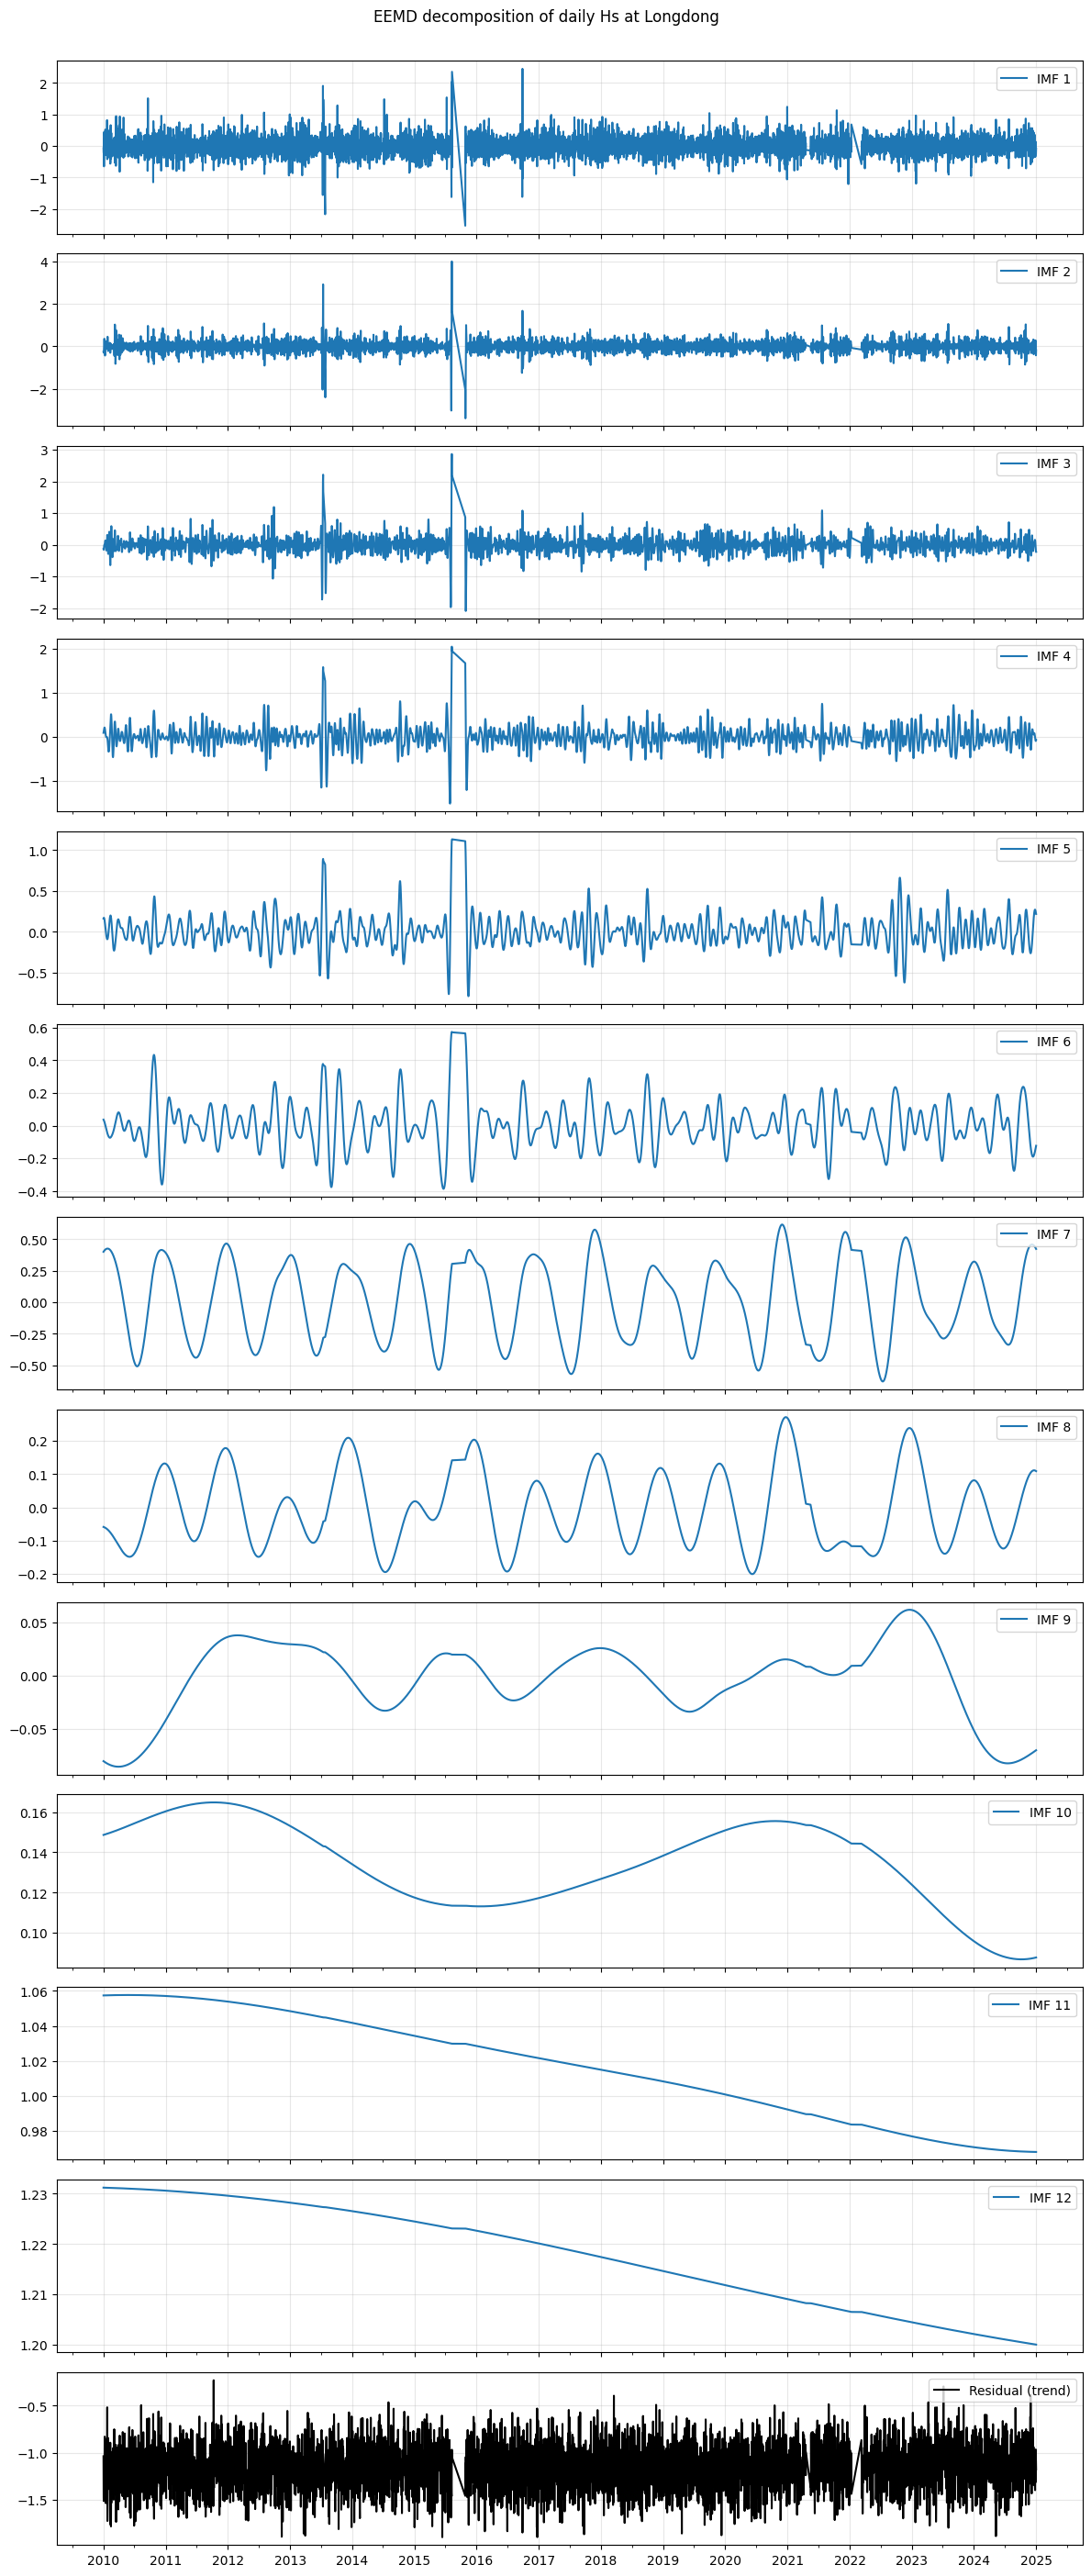

In [18]:
daily_Ld, IMF_Ld, res_Ld = plot_eemd_decomposition(master_df, 'Longdong', 'Hs')

In [19]:
# Manual banding based on IMF appearance in plot_eemd_decomposition()
# But the band_def still has problems need to be fixed......
band_def = {
    "seasonal": [6],
    "annual": [7],
    "enso": [8, 9],
    "trend": [10, 11, 12]  # optional + residual
}

def plot_eemd_summary_manual(daily, IMFs, residual, band_def, location="", clip_max=None):
    """
    Plot manually grouped EEMD bands with daily signal.

    Parameters:
        daily: pandas Series or DataFrame of daily-mean values
        IMFs: 2D ndarray of EEMD IMFs
        residual: 1D array from EEMD
        band_def: dict with lists of IMF indices (1-based)
        location: str, label for plot title
        clip_max: float, y-limit
    """
    x = daily.values

    def sum_band(keys):
        return np.sum([IMFs[i - 1] for i in band_def.get(keys, [])], axis=0) if band_def.get(keys) else np.zeros_like(x)

    seasonal = sum_band("seasonal")
    annual   = sum_band("annual")
    enso     = sum_band("enso")
    trend    = sum_band("trend") # + residual

    plt.figure(figsize=(12, 6))
    plt.plot(daily.index, np.clip(x, None, clip_max), color="lightgray", label="Daily Hs (clipped)")
    if band_def.get("seasonal"):
        plt.plot(daily.index, seasonal, color="cornflowerblue", label="Seasonal envelope")
    if band_def.get("annual"):
        plt.plot(daily.index, annual, color="cyan", label="Annual cycle")
    if band_def.get("enso"):
        plt.plot(daily.index, enso, color="orange", label="ENSO-scale")
    if band_def.get("trend"):
        plt.plot(daily.index, trend, color="firebrick", linewidth=2, label="Trend")

    # Updated axis ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.title(f"EEMD Summary of Hs at {location} (2010–2024)")
    plt.ylabel("Hs (m)")
    plt.grid(alpha=0.3)
    plt.legend()
    if clip_max:
        plt.ylim(-1, clip_max)
    plt.tight_layout()
    plt.show()



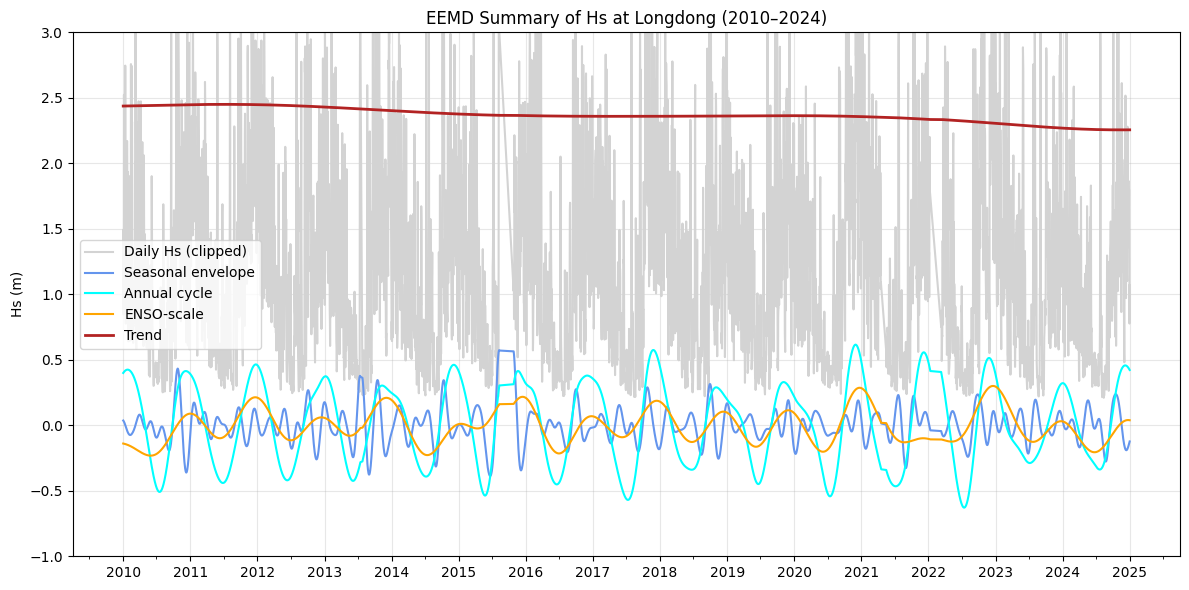

In [20]:
plot_eemd_summary_manual(daily_Ld, IMF_Ld, res_Ld, band_def, "Longdong", clip_max=3)